# Classification. Linear models and KNN

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
            loss: array, default empty
                Collect the loss function values
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.losses = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        return 1./(1. + np.exp(-X.dot(weights)))

    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>  loss = np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))  
        #    np.mean(np.log(1. + np.exp(np.matmul(-X.dot(weights), y))) + 1. / 2. * self.C * np.amin((np.linalg.norm(weights))**2)) 
        return np.mean(np.log(1+np.exp(-np.dot(x, weights)*y))).mean() + 1/(2*self.C)* np.linalg.norm(weights, ord=2)
        
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        delta = 0
        
        for i in range(self.max_iter):
            delta = X_ext.T @( y * (1. - 1. / (1 + np.exp(np.dot(-X_ext, self.weights_) * y)))) / len(y) - (1/ self.C) * self.weights_
            self.weights_ -= self.eta * delta * (-1.)
            loss = self.get_loss(X_ext, self.weights_, y)
            self.losses.append(loss)
            if self.eta  * np.linalg.norm(delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        
        return np.where(self.predict_proba(X) >= 0.5, 1, -1)

In [5]:
from sklearn import datasets
from sklearn import metrics

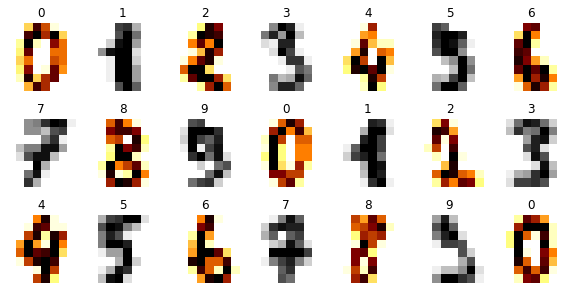

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
print(lr_clf.weights_)

[ 3.13152401e-06  0.00000000e+00  4.17536534e-05  5.47668754e-04
  2.21294363e-04  4.87473904e-04  1.35768963e-03  5.97773138e-04
  5.63674322e-05 -6.95894224e-07  1.69102296e-04  2.51913709e-04
 -4.37021573e-04  3.61864997e-04  1.00487126e-03  4.22755741e-04
  2.57480863e-05  3.47947112e-07 -1.14822547e-05 -7.24425887e-04
 -2.62004175e-04  8.75434934e-04  4.15448852e-04 -8.42032011e-05
 -5.21920668e-06  0.00000000e+00 -2.21642310e-04 -5.71329158e-04
  9.85734168e-04  1.35073069e-03  5.02087683e-04 -1.70494085e-04
 -1.04384134e-06  0.00000000e+00 -6.78148921e-04 -1.05149617e-03
 -4.45372303e-05  3.71607516e-04  4.21016006e-04 -8.17675713e-05
  0.00000000e+00 -5.21920668e-06 -5.34098817e-04 -2.03931802e-03
 -8.43075852e-04  1.04036186e-04 -1.23869172e-04 -1.78844816e-04
 -1.32219903e-05 -4.52331246e-06 -9.42936674e-05 -1.11273486e-03
 -5.09046625e-04 -2.18510786e-04 -5.60542797e-04 -3.95615866e-04
 -1.77453027e-05 -3.47947112e-07  2.67919276e-05  6.39178845e-04
  1.80932498e-04 -7.36604

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

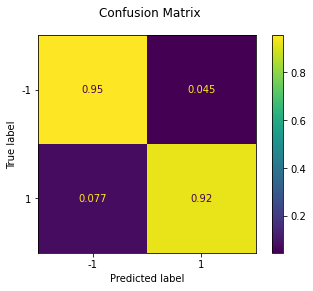

In [15]:
import warnings
warnings.filterwarnings('ignore')

train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

In [18]:
## your code
def plot(model, value):
#     plt.figure(figsize=(10, 7))
    plt.plot(model.losses, label=value)
#     plt.title('Loss History')
    plt.ylabel('loss')
    plt.xlabel('iteration')
    plt.grid(alpha=0.2)
    plt.legend()
#     plt.show()

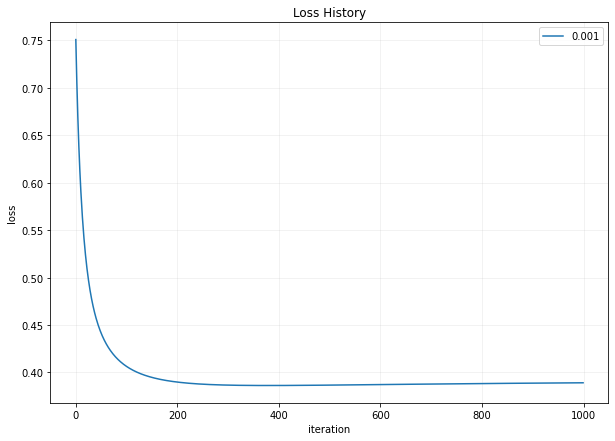

In [19]:
plt.figure(figsize=(10, 7))
plt.title('Loss History')
plot(model, model.eta)

This graph represents how the loss changed with number of iterations. It is getting close to value 0.2. The value of the loss at the beginning drops sharply and then, during the iteration, starting from 850, it practically does not change.

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

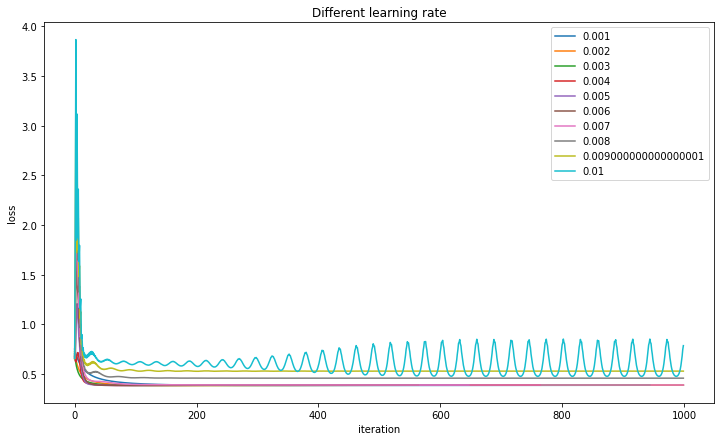

In [20]:
## your code eta

lr = np.linspace(0.001, 0.01, 10)  # value ot learning rate  
plt.figure(figsize=(12, 7))
plt.title('Different learning rate')
for eta in lr:
    model = CustomLogisticRegression(eta)
    model.fit(X_train, y_train)
    plot(model, eta)


As the learning rate increases, dergence increases. The model starts to diverge, which is especially noticeable in the oscillations of the graph for a learning rate = 0.01

**(0.5 points)** Try different regularization parameter values and compare the model quality.

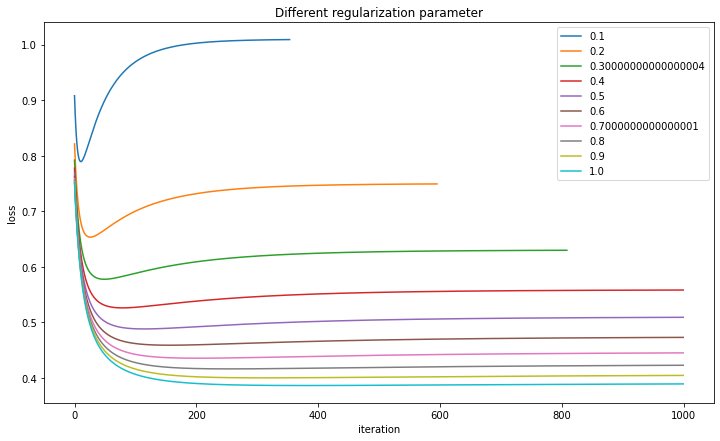

In [21]:
## your code C
# cs = np.logspace(-2, 2, 10)    # values for the regularization parameter
cs = np.linspace(0.1, 1.0, 10)
plt.figure(figsize=(12, 7))
plt.title('Different regularization parameter')
for c in cs:
    model = CustomLogisticRegression(C=c)
    model.fit(X_train, y_train)
    plot(model, c)


Regularization adds the penalty as model complexity increases. The regularization parameter penalizes all the parameters except intercept so that the model generalizes the data and won’t overfit. On the graph we can see that more regilarisation parameter makes model converges better.

**(0.5 points)** Compare zero initialization and random initialization. 

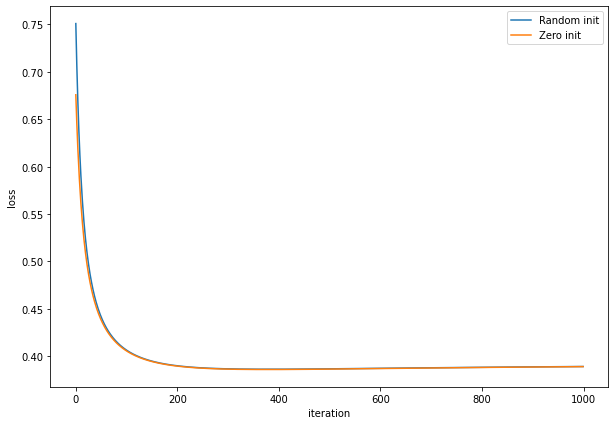

In [22]:
## your code
plt.figure(figsize=(10, 7))

model = CustomLogisticRegression(zero_init=False)
model.fit(X_train, y_train)
plot(model, 'Random init')

model = CustomLogisticRegression(zero_init=True)
model.fit(X_train, y_train)
plot(model, 'Zero init')

Converges a little faster with zero initialization, initial loss values are closer to the minimum, random weights are further from the minimum. At the end of the graph they are both random and zero initialisations match.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [28]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
#         self.classes = [] or {}
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        return np.array([[np.linalg.norm(x-y)for y in Y] for x in X])
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        weights_total = []
        dfweig = pd.DataFrame(weights,y)

        for i in self.classes:
            weight_1 = int(df_weig.loc[i].sum())
            weights_total.append(weight_1)

        return weights_total
                    
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 'your code'
                
            # <your code>
            pass
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pass

In [29]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [30]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [31]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

ValueError: operands could not be broadcast together with shapes (0,) (3,) 

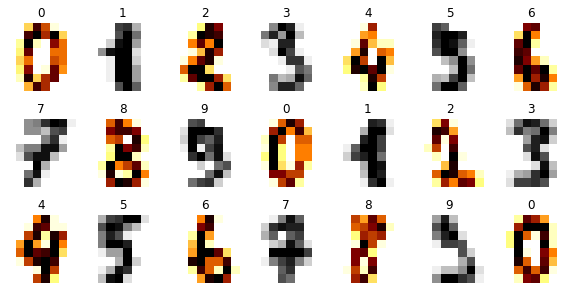

In [76]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [77]:
X_train.shape

(1437, 64)

In [78]:
y_train.shape

(1437,)

In [74]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [75]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

Minkowski distances are part of the scikit-learn DistanceMetric class and can be used to tune classifiers such as KNN or clustering alogorithms such as DBSCAN

In [ ]:
def minkowski(x1,x2,y1,y2,p):
    t=(x2-x1)**p+(y2-y1)**p
    return np.power(t,1/p)

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [96]:
PATH = "./data/"

In [97]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [98]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S




### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [43]:
## your code
data['Sex'].value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

In [44]:
data['Sex'].value_counts() / data.shape[0]

male      0.56114
female    0.43886
Name: Sex, dtype: float64

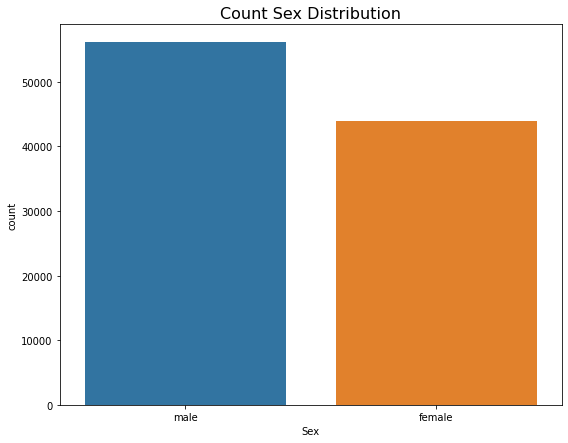

In [45]:
plt.figure(figsize=(9, 7))
ax = sns.countplot(x="Sex", data=data)
ax.set_title('Count Sex Distribution', fontsize=16);

There are 56% of male and 43% of female. The women a bit less than men.

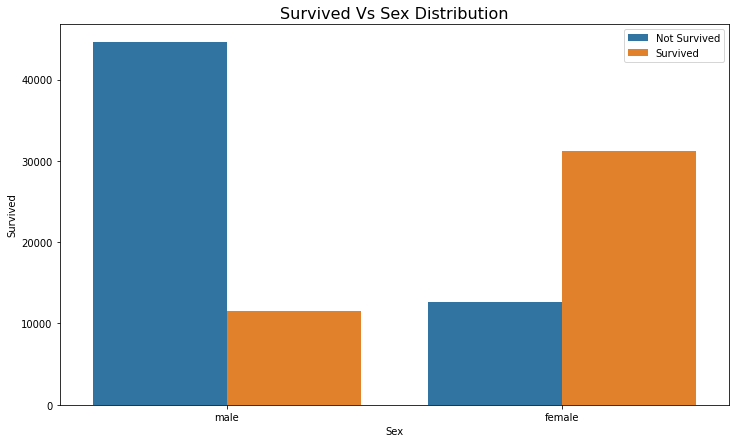

In [46]:
plt.figure(figsize=(12, 7))
plt.title('Survived Vs Sex Distribution', fontsize=16)
sns.countplot(x ="Sex", hue ="Survived", data=data).set(xlabel='Sex',ylabel="Survived")
plt.legend(labels=["Not Survived","Survived"])
plt.show()

As we can see number of Survived women much higher than men.

In [47]:
male_count = data['Sex'].value_counts()[0]
female_count = data['Sex'].value_counts()[1]
print('Survived men(%): ', round(data['Survived'][data['Sex']== 'male'].value_counts()[1]/male_count*100, 4))
print('Survived women(%): ', round(data['Survived'][data['Sex']== 'female'].value_counts()[1]/female_count*100, 4))

Survived men(%):  20.5795
Survived women(%):  71.1525


< your thoughts >

Survived women 50% more than men. It was happened because women and children were evacuated first.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

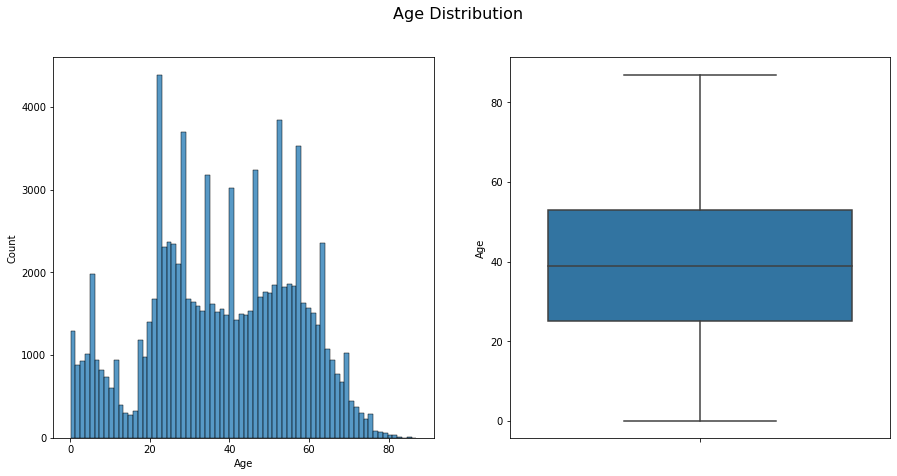

In [48]:
## your code
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Age Distribution', fontsize=16)
sns.histplot(ax=axes[0], data=data, x="Age");
sns.boxplot(ax=axes[1], data=data, y="Age");

In [49]:
data['Age'].describe()

count    96708.000000
mean        38.355472
std         18.313556
min          0.080000
25%         25.000000
50%         39.000000
75%         53.000000
max         87.000000
Name: Age, dtype: float64

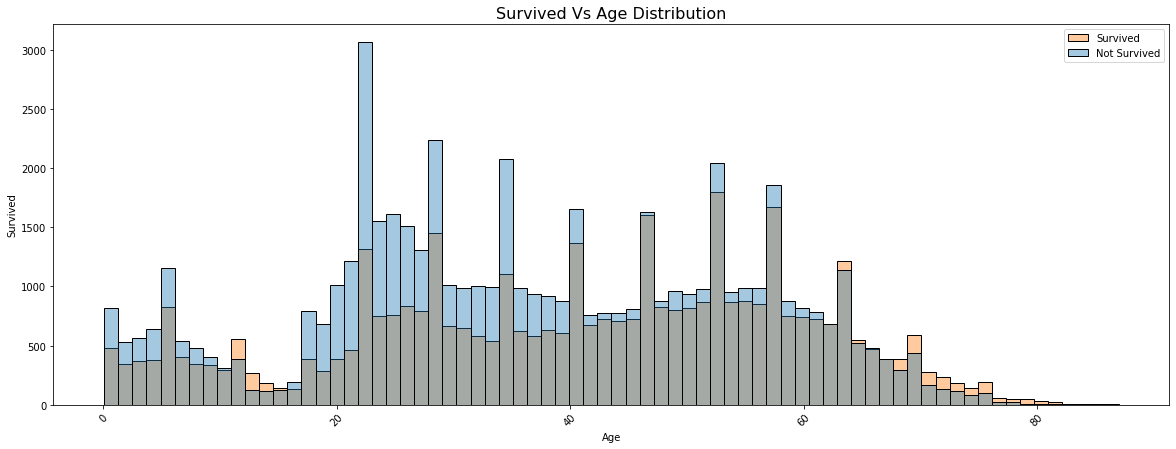

In [50]:
plt.figure(figsize=(20, 7))
plt.title('Survived Vs Age Distribution', fontsize=16)
sns.histplot(x ="Age", hue ="Survived", data=data, alpha=0.4).set(xlabel='Age',ylabel="Survived")
plt.xticks(rotation=45)
plt.legend(labels=["Survived","Not Survived"])
plt.show()

In [51]:
data.groupby(['Survived'])['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,55290.0,36.708695,17.809058,0.08,24.0,36.0,52.0,83.0
1,41418.0,40.553799,18.742172,0.08,27.0,43.0,55.0,87.0


< your thoughts >

From the describtive statistics we couldn't see much differense. From the histogram more people in age brackets from 18 to 40 not survived, more not survived with age between 0 to 10, but difference is less than in a previous age bracket. Roughly from 40 to 60 years old the same number for survived and not survived. People older than 60 have bigger percentage that's survived. I recon kids and olderly people was in priority for rescue.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

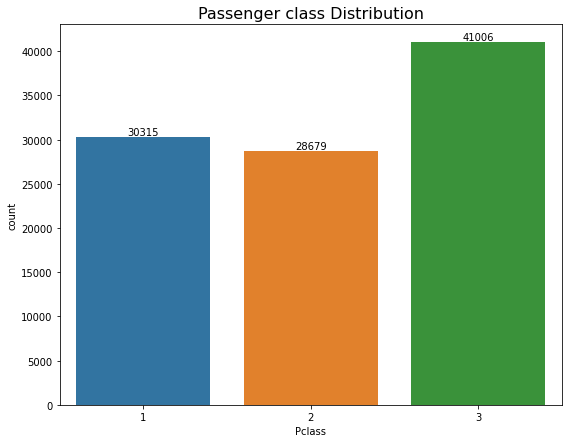

In [52]:
plt.figure(figsize=(9, 7))
ax = sns.countplot(x="Pclass", data=data)
ax.bar_label(ax.containers[0])
ax.set_title('Passenger class Distribution', fontsize=16);

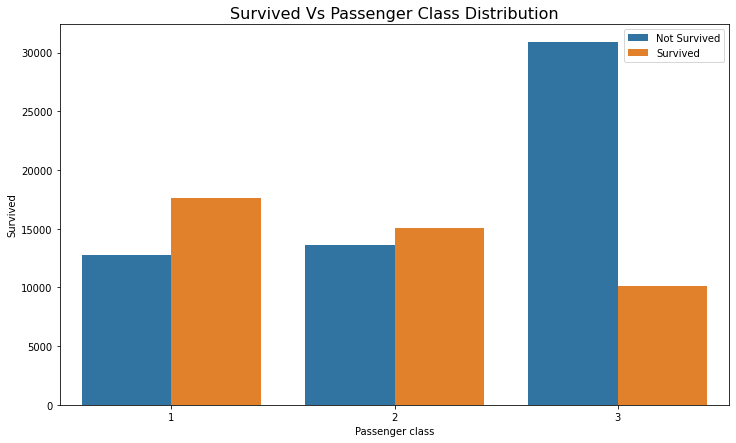

In [53]:
plt.figure(figsize=(12, 7))
plt.title('Survived Vs Passenger Class Distribution', fontsize=16)
sns.countplot(x ="Pclass", hue ="Survived", data=data).set(xlabel='Passenger class',ylabel="Survived")
plt.legend(labels=["Not Survived","Survived"])
plt.show()

There were much more people who was survived from the 1st and 2nd classes. In the second class 50/50 survived - not survived. In the third class 2/3 of people did not survived.

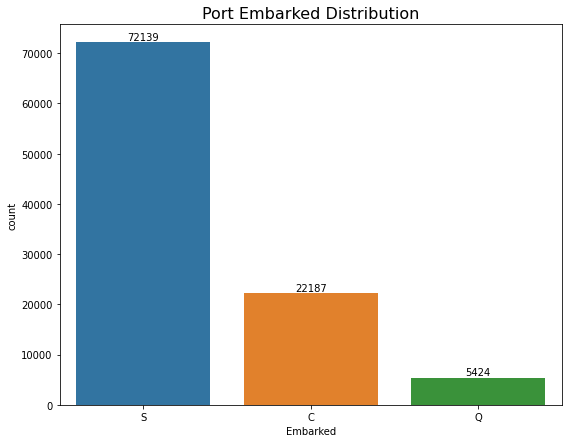

In [54]:
plt.figure(figsize=(9, 7))
ax = sns.countplot(x="Embarked", data=data)
ax.bar_label(ax.containers[0])
ax.set_title('Port Embarked Distribution', fontsize=16);

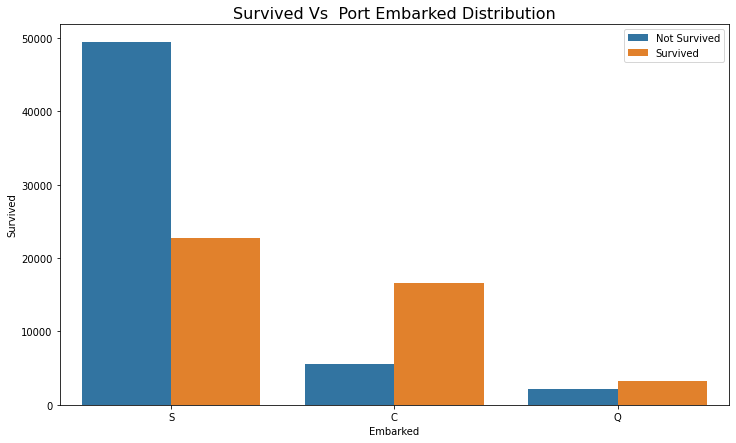

In [55]:
plt.figure(figsize=(12, 7))
plt.title('Survived Vs  Port Embarked Distribution', fontsize=16)
sns.countplot(x ="Embarked", hue ="Survived", data=data).set(xlabel='Embarked',ylabel="Survived")
plt.legend(labels=["Not Survived","Survived"])
plt.show()

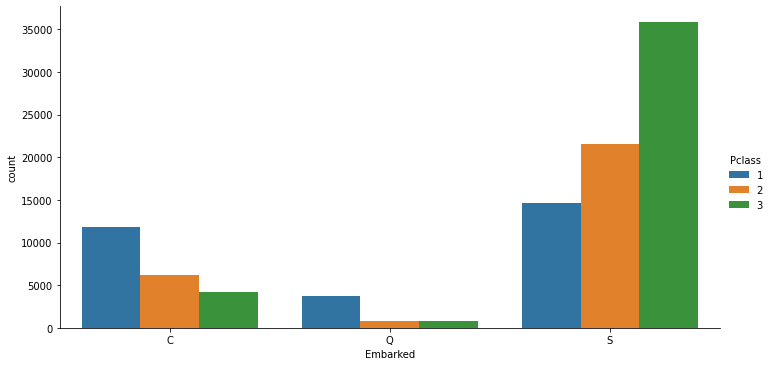

In [56]:
sns.catplot('Embarked', data=data, kind='count', hue='Pclass', hue_order=range(1,4), aspect=2, order=['C','Q','S']);

< your thoughts >

The largest number of people survived who embarked in port C (Cherbourg). More than a half survived for those who loaded in port Q (Queenstown ) and a less than a half survived who embarked in port S (Southampton). So the most chances had a old women who travel by 1st class and embarked in port C. As shown on the last graphs most of the people in Port Southampton traveled in 3rd class that's why less people survived who embarced in port Southampton.  

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

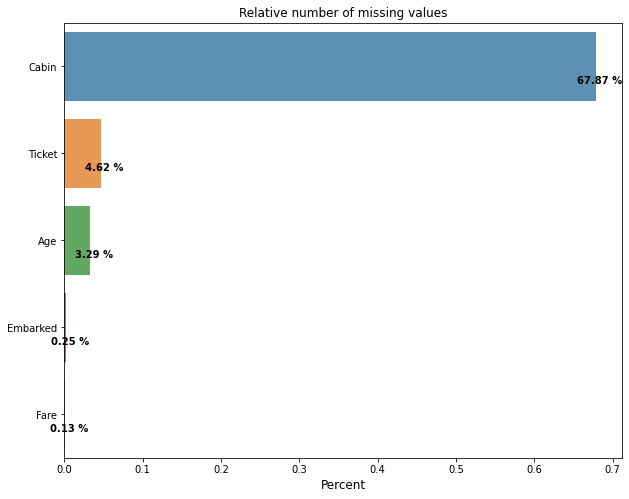

In [57]:
## your code
# percentage of missing values
per_nans = pd.DataFrame(1-data.count()/data.shape[0]).reset_index().rename({0:'percent'}, \
                                                axis=1).sort_values('percent', ascending=False).query('percent>0')
# plot missing values
fig, ax = plt.subplots(figsize = (10, 8))
bar_plot = sns.barplot(x='percent', y='index', data=per_nans, alpha=0.8, ci=None)
for ytick in bar_plot.get_yticks():
        bar_plot.text(per_nans.iloc[ytick][1]+0.005, ytick+0.2, str(round(per_nans.iloc[ytick][1]*100,2))+' %', 
                    horizontalalignment='center',size=10, color='black',weight='semibold')
plt.title('Relative number of missing values')
plt.ylabel('')
plt.xlabel('Percent', fontsize=12)
plt.show()

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

- `Cabin` a lot of missing values 67.87 and 70.83% in the column, if we could not fill them in by using tickets code it'll be better to drop this column
- `Tickets` this column have small percentage of missing values 4.62% and 5.18% may be easier drop them
- `Age` after checking distribution it is possible to fill values with mean or median
- `Embarked` 0.25% and 0.28% we can fill by mode
- `Fare` we'll make a decision after checking this rows

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

#### Missing values

In [99]:
# fill missing values with mean values
data['Age'] = data.groupby('Pclass')['Age'].transform(lambda group: group.fillna(group.mean()))
data['Fare'] = data.groupby('Pclass')['Fare'].transform(lambda group: group.fillna(group.mean()))

In [100]:
data['Embarked'] = data['Embarked'].fillna('S')

In [101]:
data.drop('Cabin', axis=1, inplace=True) # a lot of missing values

In [102]:
data.drop('Ticket', axis=1, inplace=True) # coudn't fill them in

In [103]:
data.drop('Name', axis=1, inplace=True)

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Sex       100000 non-null  object 
 3   Age       100000 non-null  float64
 4   SibSp     100000 non-null  int64  
 5   Parch     100000 non-null  int64  
 6   Fare      100000 non-null  float64
 7   Embarked  100000 non-null  object 
dtypes: float64(2), int64(4), object(2)
memory usage: 6.9+ MB


#### Models

In [105]:
X_train = data.iloc[:, 1:].copy()

In [106]:
X_train.reset_index(drop=True, inplace=True)

In [107]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,male,44.774464,2,0,27.14,S
1,3,male,33.407362,0,0,13.35,S
2,3,male,0.330000,1,2,71.29,S
3,3,male,19.000000,0,0,13.04,S
4,3,male,25.000000,0,0,7.76,S


In [108]:
X_train.shape

(100000, 7)

In [109]:
y_train = data.iloc[:, 0]

In [110]:
y_train.reset_index(drop=True, inplace=True)

In [111]:
PATH = "./data/"

In [112]:
X_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [113]:
X_test['Age'] = X_test.groupby('Pclass')['Age'].transform(lambda group: group.fillna(group.mean()))
X_test['Fare'] = X_test.groupby('Pclass')['Fare'].transform(lambda group: group.fillna(group.mean()))

In [114]:
X_test['Embarked'] = X_test['Embarked'].fillna('S')

In [115]:
X_test.drop('Cabin', axis=1, inplace=True) # a lot of missing values

In [116]:
X_test.drop('Ticket', axis=1, inplace=True) # coudn't fill them in

In [117]:
X_test.drop('Name', axis=1, inplace=True) # coudn't fill them in

In [118]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 100000 to 199999
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Pclass    100000 non-null  int64  
 1   Sex       100000 non-null  object 
 2   Age       100000 non-null  float64
 3   SibSp     100000 non-null  int64  
 4   Parch     100000 non-null  int64  
 5   Fare      100000 non-null  float64
 6   Embarked  100000 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 6.1+ MB


In [119]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
100000,3,male,19.0,0,0,63.01,S
100001,3,female,53.0,0,0,5.81,S
100002,1,female,19.0,0,0,38.91,C
100003,2,male,25.0,0,0,12.93,S
100004,1,female,17.0,0,2,26.89,C


In [120]:
X_test.shape

(100000, 7)

In [121]:
num_cols = ['Age', 'Fare', 'SibSp', 'Parch']

In [122]:
# отнормируем числовые признаки num_cols для train и test
scaler = StandardScaler()
X_train_num = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols)
X_test_num = pd.DataFrame(scaler.fit_transform(X_test[num_cols]), columns=num_cols)

In [123]:
cat_cols = ['Pclass', 'Sex', 'Embarked']

In [124]:
# закодируем категориальные признаки с помощью one-hot-encoding'а
X_train_cat = pd.get_dummies(X_train[cat_cols], columns=cat_cols)
X_test_cat = pd.get_dummies(X_test[cat_cols], columns=cat_cols)

In [125]:
X_train_cat.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,0,1,0,1,0,0,1
2,0,0,1,0,1,0,0,1
3,0,0,1,0,1,0,0,1
4,0,0,1,0,1,0,0,1


In [126]:
# соединим числовые и категориальные признаки с помощью concat
X_train = pd.concat([X_train_num.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis=1)
X_test =  pd.concat([X_test_num.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis=1)

In [127]:
X_test.head()

,Age,Fare,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,-0.836762,0.270708,-0.630852,-0.533599,0,0,1,0,1,0,0,1
1,1.623047,-0.606907,-0.630852,-0.533599,0,0,1,1,0,0,0,1
2,-0.836762,-0.099057,-0.630852,-0.533599,1,0,0,1,0,1,0,0
3,-0.402678,-0.497666,-0.630852,-0.533599,0,1,0,0,1,0,0,1
4,-0.981457,-0.283479,-0.630852,1.631851,1,0,0,1,0,1,0,0


In [135]:
from sklearn.linear_model import LogisticRegression, Ridge

In [136]:
from sklearn.model_selection import GridSearchCV

In [139]:
grid_searcher = GridSearchCV(estimator=LogisticRegression(),
                             param_grid={'C':[100, 10, 1, 0.01, 0.001]}, cv=5, scoring='accuracy')

In [140]:
grid_searcher.fit(X_train, y_train);

In [141]:
best_predictions = grid_searcher.predict(X_test)

In [142]:
print('Лучший результат', grid_searcher.best_score_,'при значении С =', grid_searcher.best_params_['C'])

Лучший результат 0.76424 при значении С = 1


In [143]:
best_model = grid_searcher.best_estimator_
score = best_model.predict_proba(X_test)
sub = pd.DataFrame({'PassengerId': range(len(score)), 'Survived': score[:,1]})
sub.to_csv('submission_logreg.csv', index=False)
sub.head(5)

,PassengerId,Survived
0,0,0.126025
1,1,0.483770
2,2,0.883384
3,3,0.241506
4,4,0.868117


In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(test_labels, y_pred)

In [164]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [165]:
clf = KNeighborsClassifier()

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code

We can join Parch and SibSp and create new column 

In [ ]:
data_train.loc[:, 'Family'] = np.where((data_train.Parch>0) | (data_train.SibSp>0), 1, 0)

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.